# Maths4DS 101
# Lab 5. Classification

Data scientists are often tasked with automating decisions for business problems. Is an email an attempt at phishing? Is a customer likely to churn? Is the web user likely to click on an advertisement? These are all classification problems, a form of supervised learning in which we first train a model on data where the outcome is known and then apply the model to data where the outcome is not known. Classification is perhaps the most important form of prediction: the goal is to predict whether a record is a 1 or a 0 (phishing/not-phishing, click/don’t click, churn/don’t churn), or in some cases, one of several categories (for example, Gmail’s filtering of your inbox into “primary,” “social,” “promotional,” or “forums”).

### Please refer to the reference book, chapter 5

[Book Chapter 5](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/ch05.html)

### for Q&A please refer to the tags #maths4ds101 and #lab5 on stackoverflow

    
[StackOverflow](https://stackoverflow.com/c/cyberblue/questions/tagged/12)

# 0. Let's Import required Python packages.

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA='../data/'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:

LOAN3000_CSV = DATA + 'loan3000.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA + 'full_train_set.csv.gz'

In [4]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# 1. Binary Classification

Logistic regression is analogous to multiple linear regression (refer to Lab 4), except the outcome is binary. Various transformations are employed to convert the problem to one in which a linear model can be fit. Like discriminant analysis, and unlike K-Nearest Neighbor and naive Bayes, logistic regression is a structured model approach rather than a data-centric approach. Due to its fast computational speed and its output of a model that lends itself to rapid scoring of new data, it is a popular method.

For instance, given some finantial data, we would be interested in predicting the ability of a customer to pay back a loan.

In [5]:
loan_data[['status','loan_amnt','term','annual_inc','purpose','home_','emp_len_','outcome']].sample(10)

,status,loan_amnt,term,annual_inc,purpose,home_,emp_len_,outcome
10034,Charged Off,5500,36 months,20000,credit_card,MORTGAGE,< 1 Year,default
4861,Charged Off,5000,36 months,24000,debt_consolidation,OWN,> 1 Year,default
3870,Charged Off,12800,36 months,141996,debt_consolidation,MORTGAGE,> 1 Year,default
31295,Fully Paid,9250,36 months,27500,debt_consolidation,RENT,> 1 Year,paid off
8853,Charged Off,10575,36 months,55000,home_improvement,MORTGAGE,> 1 Year,default
22250,Charged Off,16000,60 months,52000,other,RENT,> 1 Year,default
4403,Charged Off,6000,36 months,58000,debt_consolidation,MORTGAGE,> 1 Year,default
19952,Charged Off,18000,60 months,45000,debt_consolidation,MORTGAGE,> 1 Year,default
43666,Fully Paid,10000,36 months,85000,credit_card,MORTGAGE,> 1 Year,paid off
22311,Charged Off,10000,36 months,65000,debt_consolidation,RENT,> 1 Year,default


In contrast to Lab 4 the outcome variable is not continous but of binary nature (default/paid off). In this case linear models are not valid and we need to reformulate our model by considering: (1) the outcome in terms of probabilities of an event happening against the alternative (a.k.a Odds) and (2) logistic response functions. Refer to chapter 4 in the book for more information.

In [6]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380882883923482
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


The interpretation of the coefficients is different to that of the linear models we use in Lab 4. This time we need to interpret the outcome in terms of probabilities of paying off against defaulting.

The variable borrower_score is a score on the borrowers’ creditworthiness and ranges from 0 (low) to 1 (high). The odds of the best borrowers relative to the worst borrowers defaulting on their loans is smaller by a factor of exp(4.61264)≈100. In other words, the default risk from the borrowers with the best creditworthiness is 100 times lower than that of the worst borrowers!

On a similar note the effect of increasing the payment-to-income ratio from, say, 5 to 6 reduces the odds of the loan defaulting by a factor of exp(-0.0797)≈0.9233 

# 2. Evaluating Classification Models

It is common in predictive modeling to train a number of different models, apply each to a holdout sample, and assess their performance. Sometimes, after a number of models have been evaluated and tuned, and if there are enough data, a third holdout sample, not used previously, is used to estimate how the chosen model will perform with completely new data. Different disciplines and practitioners will also use the terms validation and test to refer to the holdout sample(s). Fundamentally, the assessment process attempts to learn which model produces the most accurate and useful predictions.

## 2.1 Confusion Matrix

At the heart of classification metrics is the confusion matrix. The confusion matrix is a table showing the number of correct and incorrect predictions categorized by type of response

In [7]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


The predicted outcomes are columns and the true outcomes are the rows. The diagonal elements of the matrix show the number of correct predictions, and the off-diagonal elements show the number of incorrect predictions. 

For example, 14336 defaulted loans were correctly predicted as a default with 14523 loans correctly classified as paid off.

8335 loans however which were predicted to be paid off failed to do so. 8148 loans predicted to default ended up being paid off.

## 2.2. Precision, Recall, and Specificity

Metrics other than pure accuracy—metrics that are more nuanced—are commonly used in evaluating classification models. Several of these have a long history in statistics—especially biostatistics, where they are used to describe the expected performance of diagnostic tests.

In [19]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))



Precision 0.6376089663760897
Recall 0.6323496978518812
Specificity 0.6405981209474659


## 2.3 ROC Curve

You can see that there is a trade-off between recall and specificity. Capturing more 1s generally means misclassifying more 0s as 1s. The ideal classifier would do an excellent job of classifying the 1s, without misclassifying more 0s as 1s.

The metric that captures this trade-off is the “Receiver Operating Characteristics” curve, usually referred to as the ROC curve.

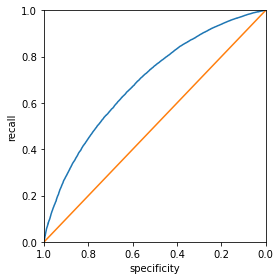

In [22]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

The result is shown in the previous figure. The orange diagonal line corresponds to a classifier no better than random chance. An extremely effective classifier will have an ROC that hugs the upper-left corner. It will correctly identify lots of 1s without misclassifying lots of 0s as 1s. 

## 2.4 AUC

The ROC curve is a valuable graphical tool, but by itself doesn’t constitute a single measure for the performance of a classifier. The ROC curve can be used, however, to produce the area underneath the curve (AUC) metric. AUC is simply the total area under the ROC curve. The larger the value of AUC, the more effective the classifier. An AUC of 1 indicates a perfect classifier: it gets all the 1s correctly classified, and it doesn’t misclassify any 0s as 1s.

In [23]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


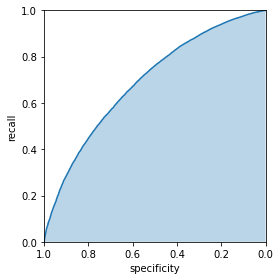

In [24]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()


In [ ]:
TODO: # 3. Ordinal Multinomial classifiers !!!

In [ ]:
TODO: confussion matrix in multiclass classifiers contexts
    